In [9]:
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import histomicstk as htk
import nucleicuts as nc

%matplotlib inline

#Some nice default configuration for plots
plt.rcParams['figure.figsize'] = 20, 7.5
plt.rcParams['axes.grid'] = True
plt.gray()

titlesize = 20
labelsize = 15
linewidth = 4

### Load input and reference images

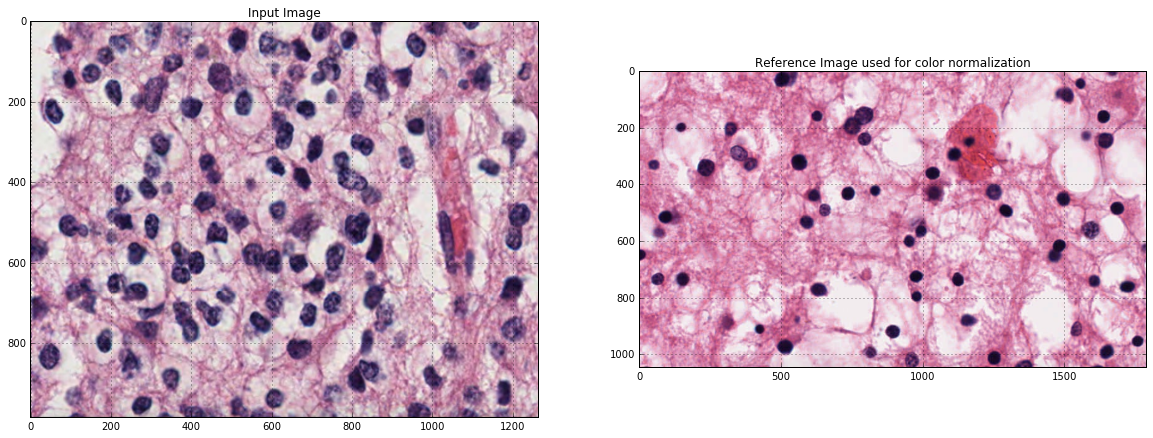

In [3]:
hard = 'https://data.kitware.com/api/v1/file/57718cc48d777f1ecd8a883f/download'
easy1 = 'https://data.kitware.com/api/v1/file/576ad39b8d777f1ecd6702f2/download'
medium4 = 'https://data.kitware.com/api/v1/file/57718cbb8d777f1ecd8a882a/download'

imInput = io.imread(medium4)[:, :, :3]
imReference = io.imread(easy1)[:, :, :3]

# show images
plt.figure()

plt.subplot(1, 2, 1)
plt.imshow(imInput)
plt.title('Input Image')

plt.subplot(1, 2, 2)
plt.imshow(imReference)
plt.title('Reference Image used for color normalization')

### Perform color normalization

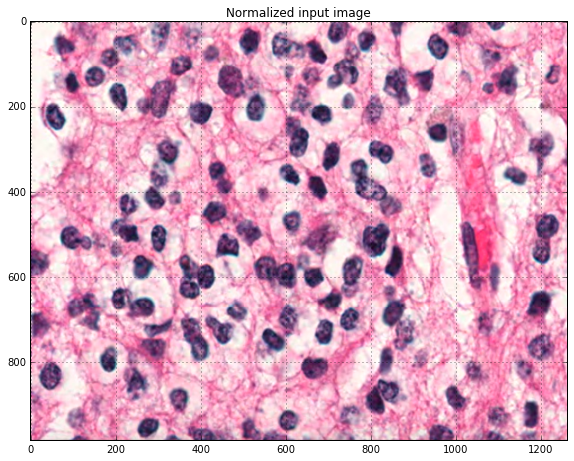

In [4]:
# transform reference image to LAB color space
imReferenceLAB = htk.RudermanLABFwd(imReference)

# compute mean and stddev of reference image in LAB color space
Mu = np.zeros(3)
Sigma = np.zeros(3)

for i in range(3):
    Mu[i] = imReferenceLAB[:, :, i].mean()
    Sigma[i] = (imReferenceLAB[:, :, i] - Mu[i]).std()
    
# perform reinhard normalization
imNmzd = htk.ReinhardNorm(imInput, Mu, Sigma)

# show results
plt.figure()
plt.imshow(imNmzd)
plt.title('Normalized input image')

### Perform color deconvolution and extract nuclear channel

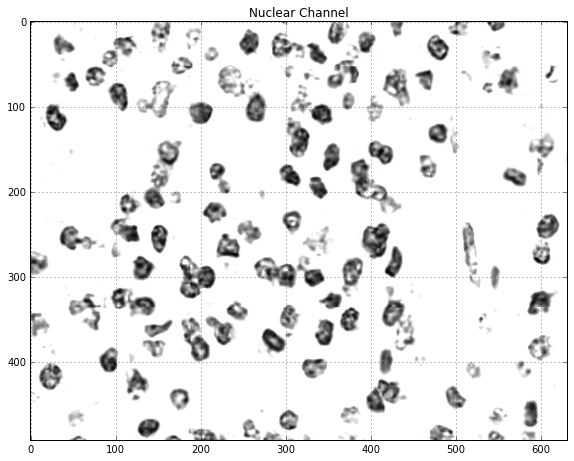

In [7]:
# create stain color matrix
stainToColorMap = {
    'hematoxylin': [0.65, 0.704, 0.286],
    'eosin':       [0.072, 0.99, 0.105],
    'dab':         [0.27, 0.57, 0.78],
    'null':        [0.0, 0.0, 0.0]
}

W = np.array([stainToColorMap['hematoxylin'],
              stainToColorMap['eosin'],
              stainToColorMap['null']]).T

# Apply ruifrok color deconvolution
res = htk.ColorDeconvolution(imNmzd, W)

# extract nuclear channel
imNuclearChannel = res.Stains[::2, ::2, 0].astype(dtype=np.uint8)

# show results
plt.figure()
plt.imshow(imNuclearChannel)
plt.title('Nuclear Channel')

### Segment nuclei using a graph-cut based algorithm

10


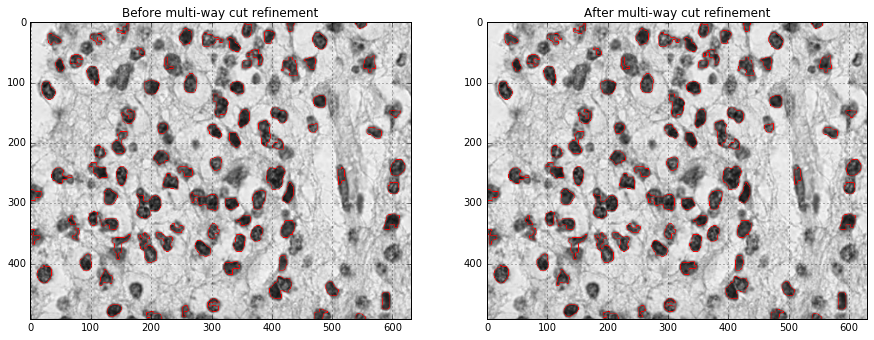

In [10]:
Label, Refined = nuclear_cut(imNuclearChannel, Sigma=25, SigmaMin=10*(2**0.5),
                             SigmaMax=15*(2**0.5), r=10,
                             MinArea=20, MinWidth=5, Background=1e-4,
                             Smoothness=1e-3)


# show results
plt.figure(figsize=(15, 10))

plt.subplot(1, 2, 1)
plt.imshow(htk.EmbedBounds(imInput[::2, ::2, 0],
                           htk.LabelPerimeter(Label) > 0,
                           Color=[255, 0, 0]))
plt.title('Before multi-way cut refinement')

plt.subplot(1, 2, 2)
plt.imshow(htk.EmbedBounds(imInput[::2, ::2, 0],
                           htk.LabelPerimeter(Refined) > 0,
                           Color=[255, 0, 0]))
plt.title('After multi-way cut refinement')